In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

## Load data

In [2]:
path_to_data = '/home/dafne/shared/FilterBubble/topic-modeling/'
# fname = os.path.join(path_to_data, 'texts_rens.csv')

# data = pd.read_csv(fname)
data = pd.read_csv(os.path.join(path_to_data, 'Felicia-Archive', 'preprocessed.csv'))

In [3]:
data.head()

,ID,topic,date,text,text_prep,topic_name,sample
0,#100 @328419 +2073,99,1/16/1999,De andere wereld van zondagmorgen. Antropoloog...,wereld zondagmorg antropolog dr mattijs port d...,Other issue,test
1,#10000 @16311398 +11159,16,12/6/2008,"SAMENVATTINGDE SPEURTOCHT VAN EFRAIM ZUROFF, n...",samenvattingd speurtocht efraim zuroff nazijag...,Defense,test
2,#10004 @16327565 +1346,16,12/5/2008,Vol verwachting kloppen de hartjes van onze st...,vol verwacht klopp hartjes onz stoer mann oero...,Defense,train
3,#10004 @34719038 +2546,5,5/1/2001,Wie als nieuwkomer bij een bedrijf denkt dat h...,nieuwkomer bedrijf denkt flink salaris gestege...,Labor and employment,train
4,#10005 @37431676 +6256,3,5/7/2001,In ziekenhuizen in Hengelo en Leeuwarden wordt...,ziekenhuiz hengelo leeuward vandag gestaaktw w...,Health,train


## Explore topics

In [4]:
# # What are the topic_six categories?
# for topic in sorted(data.topic_six.unique()):
#     print(topic)
#     print(data[data.topic_six==topic].topic_name.value_counts())

In [5]:
# Check headlines of topics
for topic in data.topic_name.value_counts().index:
    print(topic)
    print(data[data.topic_name==topic].text[:30].apply(lambda t: t[:300]).values)
    print('\n')

Government operations
['Het politieke leven van staatssecretaris H. van Hoof (VVD) heeft aan een zijdendraadje gehangen. De bewindsman van Defensie was dinsdag, op de eerste dag vanhet debat over de vuurwerkramp in Enschede, al bereid zijn ontslag in te dienenbij koningin Beatrix.Het eerste optreden van Van Van Hoof deed d'
 "De Britse overheid zal iedere pasgeboren baby een kraampresentje van minimaalduizend gulden geven. Premier Blair lanceerde gisteren het 'grote plan' voorzijn tweede ambtstermijn, dat van Groot-Brittannie een land moet maken 'metkansen voor iedereen'.De nieuwe Labourregering zal een miljard pond best"
 'Ben je gestrand in Bangkok, duikt ineens Sinterklaas met een aantal Pieten op.De goedheilig man laat de Nederlanders nergens in de steek. De reizigers warenuitgenodigd door de vereniging van de Nederlandse expatgemeenschap om hetSinterklaasfeest te komen vieren. Velen weten niet wanneer ze naar huis'
 "Minister De Grave (Defensie) heeft gisteren aan het eind van het

 "door Theo BestemanDEN HAAG, vrijdagDe tijd van stijf stilstaande paleiswachten is voorbij. De KoninklijkeMarechaussee mag tegen de verveling ook verder voor de paleisdeuren gaanrondlopen om de cirkel van beveiliging te vergroten.Met de 'mobiele' bewakers hoopt het ministerie van Defensie de werklust"]


Weather and natural disasters
['Dikke, donkere rookpluimen stijgen op van het Italiaanse eiland Sicilie, waar devulkaan Etna sinds zondag grote hoeveelheden lava en as uitstoot. Hetvulkaangeweld ging gisteren gepaard met een aardbeving van 4,4 op de schaal vanRichter. De schok leidde tot grote paniek in het dorp Santa Venerina, te'
 'Delen van Frankrijk, Zwitserland, Italie en Duitsland hebben de afgelopen nachtte kampen gehad met hevig noodweer. Daardoor zijn zeker vier doden gevallen.Enkele mensen worden nog vermist.Rampen en ongevallen ; Meteorologie ; Wetenschap en Techniek ; ExacteWetenschappen'
 'Van onze verslaggeversAMSTERDAM, zondagHevig noodweer en aanhoudend lage temperatur

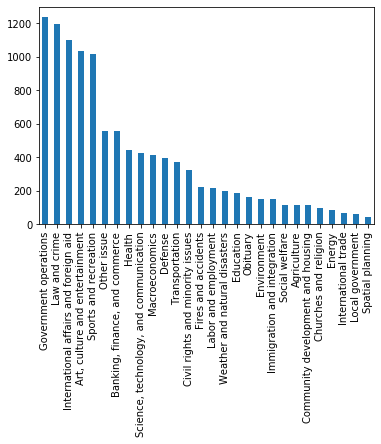

In [6]:
data.topic_name.value_counts().plot(kind='bar')

In [7]:
data.groupby(['topic', 'topic_name']).count()['ID']

topic  topic_name                            
1      Macroeconomics                             412
2      Civil rights and minority issues           322
3      Health                                     444
4      Agriculture                                114
5      Labor and employment                       217
6      Education                                  186
7      Environment                                150
8      Energy                                      81
9      Immigration and integration                149
10     Transportation                             371
12     Law and crime                             1197
13     Social welfare                             115
14     Community development and housing          114
15     Banking, finance, and commerce             556
16     Defense                                    393
17     Science, technology, and communication     426
18     International trade                         66
19     International affairs and for

## Data cleaning / selection

In [8]:
topic_nonpol = [23, 28, 29, 30, 31, 99]
data['topic_binary'] = [0 if t in topic_nonpol else 1 for t in data['topic']]

In [9]:
#data_sub = data[data.code.isin(topic_sub)].dropna(subset=['text'])
#data_sub = data.dropna(subset=['text', 'topic_six']).sample(5000)
data_train = data[data['sample']=='train'] #data.sample(4000)

## Classification pipeline

In [41]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import PassiveAggressiveClassifier, SGDClassifier
from sklearn import metrics

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(data_train.text_prep.values, 
                                                  data_train.topic_binary, 
                                                  test_size=0.33, 
                                                  random_state=0, 
                                                  stratify=data_train.topic_binary)

In [42]:
from sklearn.pipeline import Pipeline
text_clf = Pipeline([
     ('vect', CountVectorizer(min_df=5, max_df=0.9)),
     ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier())
     #('clf', PassiveAggressiveClassifier())
])

In [66]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import scipy.stats

parameters = {
     'vect__ngram_range': [(1, 1), (1, 2)],
     'vect__min_df': scipy.stats.randint(2, 5),
    'vect__max_df': scipy.stats.uniform(0.8, 0.2),
     #'tfidf__use_idf': (True, False),
    # 'clf__class_weight': ('balanced', None),
#     'clf__alpha': [0.00001, 0.0001, 0.001]
    #'clf__C': scipy.stats.uniform(0, 2)
}


In [86]:
data_train_sub = data_train.sample(1000)

In [87]:
# Try multiple classifiers
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

classifiers = [('NaiveBayes', MultinomialNB(), {}),
              ('PassiveAgressive', PassiveAggressiveClassifier(), {'clf__class_weight': ('balanced', None)}),
              ('RandomForest', RandomForestClassifier(), {}),
               ('SVM', SGDClassifier(), {'clf__class_weight': ('balanced', None),
                                                        'clf__alpha': [0.00001, 0.0001, 0.001]})]
              
gs_clfs ={}
for cname, clf, clf_params in classifiers:
    text_clf = Pipeline([
             ('vect', CountVectorizer(min_df=5, max_df=0.9)),
             ('tfidf', TfidfTransformer()),
            ('clf', clf)
        ])
    p = parameters.copy()
    p.update(clf_params)
    gs_clfs[cname] = RandomizedSearchCV( #GridSearchCV(
            text_clf, p, cv=5, iid=False, n_jobs=-1, 
                      scoring=['f1','precision', 'recall'],refit='f1')
    gs_clfs[cname].fit(data_train_sub.text_prep, data_train_sub.topic_binary)

/home/dafne/anaconda3/envs/filterbubble/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/dafne/anaconda3/envs/filterbubble/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/dafne/anaconda3/envs/filterbubble/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/dafne/anaconda3/envs/filterbubble/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in

/home/dafne/anaconda3/envs/filterbubble/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/dafne/anaconda3/envs/filterbubble/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/dafne/anaconda3/envs/filterbubble/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/dafne/anaconda3/envs/filterbubble/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in

In [93]:
results_cv = pd.DataFrame()
for cname in gs_clfs:
    results_sub = pd.DataFrame(gs_clfs[cname].cv_results_)
    results_sub['classifier'] = cname
    results_cv = results_cv.append(results_sub, ignore_index=True)

In [94]:
results_cv

,classifier,mean_fit_time,mean_score_time,mean_test_f1,mean_test_precision,mean_test_recall,param_clf__alpha,param_clf__class_weight,param_vect__max_df,param_vect__min_df,...,split3_test_precision,split3_test_recall,split4_test_f1,split4_test_precision,split4_test_recall,std_fit_time,std_score_time,std_test_f1,std_test_precision,std_test_recall
0,NaiveBayes,1.675585,0.511975,0.856888,0.749701,1.000000,NaN,NaN,0.861464,3,...,0.766304,1.000000,0.846847,0.734375,1.000000,0.229854,0.165977,0.008238,0.012599,0.000000
1,NaiveBayes,1.576821,0.456684,0.840518,0.724941,1.000000,NaN,NaN,0.943096,2,...,0.734375,1.000000,0.841791,0.726804,1.000000,0.133899,0.091648,0.005076,0.007541,0.000000
2,NaiveBayes,1.282233,0.379640,0.840518,0.724941,1.000000,NaN,NaN,0.85628,2,...,0.734375,1.000000,0.841791,0.726804,1.000000,0.015504,0.029948,0.005076,0.007541,0.000000
3,NaiveBayes,0.450175,0.270208,0.866341,0.764288,1.000000,NaN,NaN,0.873447,4,...,0.758065,1.000000,0.857143,0.750000,1.000000,0.018379,0.083623,0.008078,0.012609,0.000000
4,NaiveBayes,0.439189,0.216308,0.866341,0.764288,1.000000,NaN,NaN,0.967161,4,...,0.758065,1.000000,0.857143,0.750000,1.000000,0.008296,0.008380,0.008078,0.012609,0.000000
5,NaiveBayes,0.435641,0.222344,0.842517,0.727914,1.000000,NaN,NaN,0.871685,2,...,0.738220,1.000000,0.841791,0.726804,1.000000,0.003939,0.008937,0.004556,0.006799,0.000000
6,NaiveBayes,1.303215,0.358265,0.866375,0.764374,1.000000,NaN,NaN,0.872286,4,...,0.762162,1.000000,0.857143,0.750000,1.000000,0.010752,0.012199,0.009408,0.014658,0.000000
7,NaiveBayes,1.292468,0.364207,0.856888,0.749701,1.000000,NaN,NaN,0.861397,3,...,0.766304,1.000000,0.846847,0.734375,1.000000,0.013321,0.016097,0.008238,0.012599,0.000000
8,NaiveBayes,0.437473,0.215071,0.866341,0.764288,1.000000,NaN,NaN,0.888729,4,...,0.758065,1.000000,0.857143,0.750000,1.000000,0.003148,0.008203,0.008078,0.012609,0.000000
9,NaiveBayes,0.436489,0.216783,0.857955,0.751360,1.000000,NaN,NaN,0.917183,3,...,0.766304,1.000000,0.849398,0.738220,1.000000,0.006027,0.007303,0.009250,0.014162,0.000000


In [95]:
target_names = ['non-political', 'political']#[topic_names[i] for i in sorted(topic_sub)]

In [96]:
results_cv.columns

Index(['classifier', 'mean_fit_time', 'mean_score_time', 'mean_test_f1',
       'mean_test_precision', 'mean_test_recall', 'param_clf__alpha',
       'param_clf__class_weight', 'param_vect__max_df', 'param_vect__min_df',
       'param_vect__ngram_range', 'params', 'rank_test_f1',
       'rank_test_precision', 'rank_test_recall', 'split0_test_f1',
       'split0_test_precision', 'split0_test_recall', 'split1_test_f1',
       'split1_test_precision', 'split1_test_recall', 'split2_test_f1',
       'split2_test_precision', 'split2_test_recall', 'split3_test_f1',
       'split3_test_precision', 'split3_test_recall', 'split4_test_f1',
       'split4_test_precision', 'split4_test_recall', 'std_fit_time',
       'std_score_time', 'std_test_f1', 'std_test_precision',
       'std_test_recall'],
      dtype='object')

In [104]:
param_columns = [c for c in results_cv.columns if c.startswith('param_')]
results_cv_overview = results_cv.sort_values('mean_test_f1')[['classifier'] + param_columns + 
                                       ['mean_test_f1', 'mean_test_precision', 'mean_test_recall']]
results_cv_overview

,classifier,param_clf__alpha,param_clf__class_weight,param_vect__max_df,param_vect__min_df,param_vect__ngram_range,mean_test_f1,mean_test_precision,mean_test_recall
26,RandomForest,NaN,NaN,0.963105,4,"(1, 1)",0.832482,0.834248,0.831445
20,RandomForest,NaN,NaN,0.928026,2,"(1, 1)",0.833764,0.822820,0.845650
1,NaiveBayes,NaN,NaN,0.943096,2,"(1, 2)",0.840518,0.724941,1.000000
2,NaiveBayes,NaN,NaN,0.85628,2,"(1, 2)",0.840518,0.724941,1.000000
29,RandomForest,NaN,NaN,0.885045,4,"(1, 2)",0.840821,0.855721,0.827250
28,RandomForest,NaN,NaN,0.830563,3,"(1, 1)",0.841252,0.838844,0.844211
21,RandomForest,NaN,NaN,0.95811,4,"(1, 1)",0.842373,0.837462,0.848497
22,RandomForest,NaN,NaN,0.930015,3,"(1, 2)",0.842469,0.844091,0.841384
5,NaiveBayes,NaN,NaN,0.871685,2,"(1, 1)",0.842517,0.727914,1.000000
27,RandomForest,NaN,NaN,0.9223,2,"(1, 1)",0.846822,0.842233,0.852682


In [116]:
fname_results = '/home/dafne/shared/FilterBubble/topic-modeling/results-binary-classifier.csv'
results_cv_overview.to_csv(fname_results,index=False)

In [98]:
print(param_columns)

['param_clf__alpha', 'param_clf__class_weight', 'param_vect__max_df', 'param_vect__min_df', 'param_vect__ngram_range']


In [122]:
results_cv_overview['param_clf__class_weight'] = results_cv_overview['param_clf__class_weight'].fillna('-')

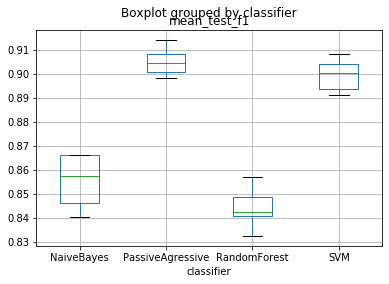

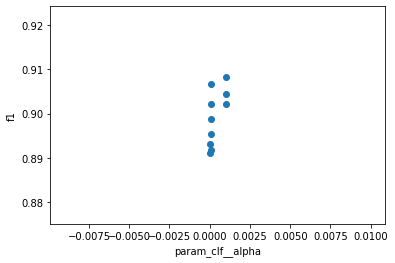

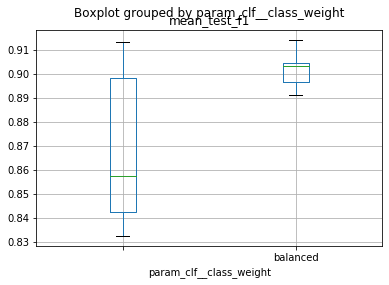

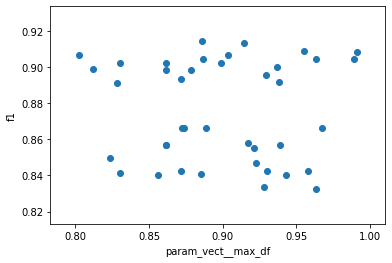

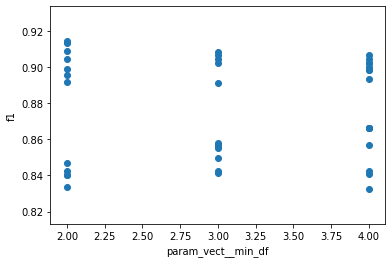

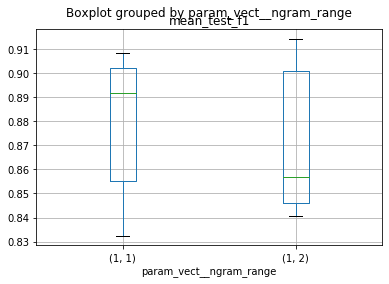

In [127]:
import numbers
for p in ['classifier'] + param_columns:
    if isinstance(results_cv_overview[p][0], numbers.Number):
        plt.scatter(results_cv_overview[p], results_cv_overview['mean_test_f1'])
        plt.xlabel(p)
        plt.ylabel('f1')
        plt.show()
    else:
        results_cv_overview.boxplot('mean_test_f1', by=p)
        plt.show()

## Apply on test set

In [128]:
data_test = data[data['sample']=='test']

In [129]:
# Train on complete train data set
clf = gs_clfs['PassiveAgressive'].best_estimator_ 
clf.fit(data_train['text_prep'], data_train['topic_binary'])

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True,
                                 max_df=0.8860292174077455, max_features=None,
                                 min_df=2, ngram_range=(1, 2),
                                 preprocessor=None, stop_words=None,
                                 strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None...
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 PassiveAggressiveClassifier(C=1.0, average=False,
                                             class_weight='balanced',
           

In [135]:
classifier = clf.named_steps['clf']
feature_weights = classifier.coef_
vect = clf.named_steps['vect']

In [161]:
words_neg = np.array(vect.get_feature_names())[np.argsort(feature_weights)[0][:100]]
words_pos = np.array(vect.get_feature_names())[np.argsort(feature_weights)[0][-100:]]

print(words_neg)
print(words_pos)

['club' 'ongeluk' 'overled' '1922' 'sport' 'kerk' 'kunst' 'brand'
 'culturel' 'echt' 'museum' 'cultur' 'laura' 'wissel bewolkt' 'vuurwerk'
 'noordwest' 'borsato' 'ploeg' 'kunstenar' 'hotel' 'media' 'toestel'
 'ajax' 'marco' 'wedstrijd' 'wk' 'tocht' 'mooi' 'dichter' 'fotospecial'
 'omroep' 'zout' 'kauwgom' 'inzit' 'boek' 'pagina 13' 'tafel' 'maxima 19'
 'verdronk' 'festival' 'omgekom' '19 22' 'muziek' 'weeroverzicht21'
 'voetbal' 'evenement' 'afen toe' '5opinie' 'olympisch' 'gelov'
 'neergestort' 'fifa' 'boekenâ' 'beroemd' '13 grad' 'publiek' 'enig'
 'nederlander' 'favoriet' 'film' 'quiz' 'ek' 'stel' 'chroesjtsjov'
 'brandlucht' 'sport7' 'collectie' 'spel' 'priester' '49' 'zwaargewond'
 'gistermiddag' 'voord' 'meest droogmorg' 'uefa' 'duitser' 'grot zal'
 'reg maxima' 'afen' '27 mei' 'brandwer' 'minder koud' 'onweersbui middag'
 'krajicek' 'seizoen' 'ensched' 'gewond' 'titel' 'complet' 'excuses'
 'abou' 'blatter' 'col' 'feyenoord' 'speler' 'oplag' 'hel' 'magazin' 'zev'
 'herkstroter']
[

In [162]:
predicted = clf.predict(data_test['text_prep'])

In [163]:
print(metrics.classification_report(data_test['topic_binary'], predicted, target_names=target_names))

               precision    recall  f1-score   support

non-political       0.84      0.72      0.77       616
    political       0.90      0.95      0.92      1591

     accuracy                           0.88      2207
    macro avg       0.87      0.83      0.85      2207
 weighted avg       0.88      0.88      0.88      2207



In [164]:
pd.DataFrame(metrics.confusion_matrix(data_test['topic_binary'], predicted), 
             index=target_names, columns=target_names)

,non-political,political
non-political,441,175
political,82,1509
